**Install Dependencies**

In [5]:
!pip install networkx pandas numpy plotly matplotlib powerlaw seaborn scipy python-louvain

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


**Import Libraries**

In [6]:
import networkx as nx
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import powerlaw
import seaborn as sns
import scipy.stats as stats
import community as community_louvain
import gzip

**Visualisasi Network**

The network was generated using email data from a large European research institution.The e-mails only represent communication between institution members (the core), and the dataset does not contain incoming messages from or outgoing messages to the rest of the world. The dataset also contains "ground-truth" community memberships of the nodes. Each individual belongs to exactly one of 42 departments at the research institute.

In [7]:
# Baca edges
def read_edges(filename):
    edges = []
    with gzip.open(filename, 'rt') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 2:
                source = int(parts[0])
                target = int(parts[1])
                edges.append((source, target))
    return edges

# Baca edges dan departments
edges = read_edges("email-Eu-core.txt.gz")
departments = pd.read_csv("email-Eu-core-department-labels.txt.gz", sep=" ", header=None, names=["node", "department"])

# Membuat Directed Graph
DG = nx.DiGraph(edges)

# Menambahkan atribut department
dept_dict = dict(zip(departments['node'], departments['department']))
nx.set_node_attributes(DG, dept_dict, 'department')

# Fungsi untuk visualisasi network interaktif
def visualize_network(G, title="Email Network Visualization"):
    # Menggunakan spring layout untuk posisi node
    pos = nx.spring_layout(G, k=0.5, seed=42)  # Tambahkan seed untuk reproduksibilitas
    
    # Ekstrak koordinat
    x_nodes = [pos[node][0] for node in G.nodes()]
    y_nodes = [pos[node][1] for node in G.nodes()]
    
    # Warna berdasarkan departemen
    departments = list(nx.get_node_attributes(G, 'department').values())
    unique_departments = list(set(departments))
    color_map = px.colors.qualitative.Set3
    
    # Membuat node colors
    node_colors = [color_map[unique_departments.index(dept) % len(color_map)] for dept in departments]
    
    # Membuat edge traces
    edge_x, edge_y = [], []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
    
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')
    
    node_trace = go.Scatter(
        x=x_nodes, y=y_nodes,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='Viridis',
            color=node_colors,
            size=10,
            colorbar=dict(
                thickness=15,
                title='Departments',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))
    
    # Tambahkan informasi node
    node_trace.text = [f"Node {node}<br>Department: {dept_dict.get(node, 'Unknown')}" for node in G.nodes()]
    
    # Layout
    layout = go.Layout(
        title=title,
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20,l=5,r=5,t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )
    
    # Gabungkan trace
    fig = go.Figure(data=[edge_trace, node_trace], layout=layout)
    
    return fig

# Visualisasi network keseluruhan
full_network_fig = visualize_network(DG, "Full Email Network (Directed)")
full_network_fig.show()

# Analisis tambahan
print(f"Total Nodes: {DG.number_of_nodes()}")
print(f"Total Edges: {DG.number_of_edges()}")
print(f"Network Density: {nx.density(DG)}")

# Centrality Analysis
in_degree_centrality = nx.in_degree_centrality(DG)
out_degree_centrality = nx.out_degree_centrality(DG)
betweenness_centrality = nx.betweenness_centrality(DG)

print("\nTop 5 Nodes by In-Degree Centrality:")
top_in_degree_nodes = sorted(in_degree_centrality, key=in_degree_centrality.get, reverse=True)[:5]
for node in top_in_degree_nodes:
    print(f"Node {node}: In-Degree Centrality = {in_degree_centrality[node]:.4f}, Department: {dept_dict.get(node, 'Unknown')}")

print("\nTop 5 Nodes by Out-Degree Centrality:")
top_out_degree_nodes = sorted(out_degree_centrality, key=out_degree_centrality.get, reverse=True)[:5]
for node in top_out_degree_nodes:
    print(f"Node {node}: Out-Degree Centrality = {out_degree_centrality[node]:.4f}, Department: {dept_dict.get(node, 'Unknown')}")

Total Nodes: 1005
Total Edges: 25571
Network Density: 0.025342411448732432

Top 5 Nodes by In-Degree Centrality:
Node 160: In-Degree Centrality = 0.2112, Department: 36
Node 62: In-Degree Centrality = 0.1783, Department: 36
Node 107: In-Degree Centrality = 0.1683, Department: 36
Node 121: In-Degree Centrality = 0.1564, Department: 36
Node 86: In-Degree Centrality = 0.1534, Department: 36

Top 5 Nodes by Out-Degree Centrality:
Node 160: Out-Degree Centrality = 0.3327, Department: 36
Node 82: Out-Degree Centrality = 0.2261, Department: 36
Node 121: Out-Degree Centrality = 0.2211, Department: 36
Node 107: Out-Degree Centrality = 0.2032, Department: 36
Node 86: Out-Degree Centrality = 0.2012, Department: 36


In [8]:
# Fungsi untuk zoom ke subgraph
def zoom_subgraph(G, department):
    # Filter nodes dari departemen tertentu
    dept_nodes = [n for n, d in G.nodes(data=True) if d.get('department') == department]
    subgraph = G.subgraph(dept_nodes)
    
    return visualize_network(subgraph, f"Subgraph for Department {department}")

# Contoh zoom ke salah satu departemen
first_department = list(set(departments['department']))[0]
dept_subgraph_fig = zoom_subgraph(DG, first_department)
dept_subgraph_fig.show()

# Tambahan: Distribusi Departemen
dept_distribution = departments['department'].value_counts()
print("\nDistribusi Nodes per Departemen:")
print(dept_distribution)


Distribusi Nodes per Departemen:
4     109
14     92
1      65
21     61
15     55
7      51
0      49
10     39
17     35
9      32
19     29
11     29
6      28
23     27
13     26
16     25
22     25
36     22
8      19
5      18
37     15
20     14
35     13
34     13
38     13
3      12
27     10
2      10
26      9
32      9
28      8
31      8
25      6
24      6
29      5
30      4
40      4
12      3
39      3
41      2
18      1
33      1
Name: department, dtype: int64


##  **Perhitungan network‘s metrics**

**Centrality Measures: Degree, Betweenness, Closeness, Eigen, PageRank**


Top 10 Nodes - Degree Centrality:
Node 160: Value = 0.5438, Department: 36
Node 121: Value = 0.3775, Department: 36
Node 107: Value = 0.3715, Department: 36
Node 62: Value = 0.3675, Department: 36
Node 86: Value = 0.3546, Department: 36
Node 82: Value = 0.3466, Department: 36
Node 434: Value = 0.3068, Department: 34
Node 183: Value = 0.3008, Department: 4
Node 5: Value = 0.2789, Department: 25
Node 129: Value = 0.2739, Department: 4

Top 10 Nodes - In Degree Centrality:
Node 160: Value = 0.2112, Department: 36
Node 62: Value = 0.1783, Department: 36
Node 107: Value = 0.1683, Department: 36
Node 121: Value = 0.1564, Department: 36
Node 86: Value = 0.1534, Department: 36
Node 434: Value = 0.1504, Department: 34
Node 183: Value = 0.1424, Department: 4
Node 129: Value = 0.1384, Department: 4
Node 64: Value = 0.1355, Department: 25
Node 128: Value = 0.1315, Department: 5

Top 10 Nodes - Out Degree Centrality:
Node 160: Value = 0.3327, Department: 36
Node 82: Value = 0.2261, Department: 36


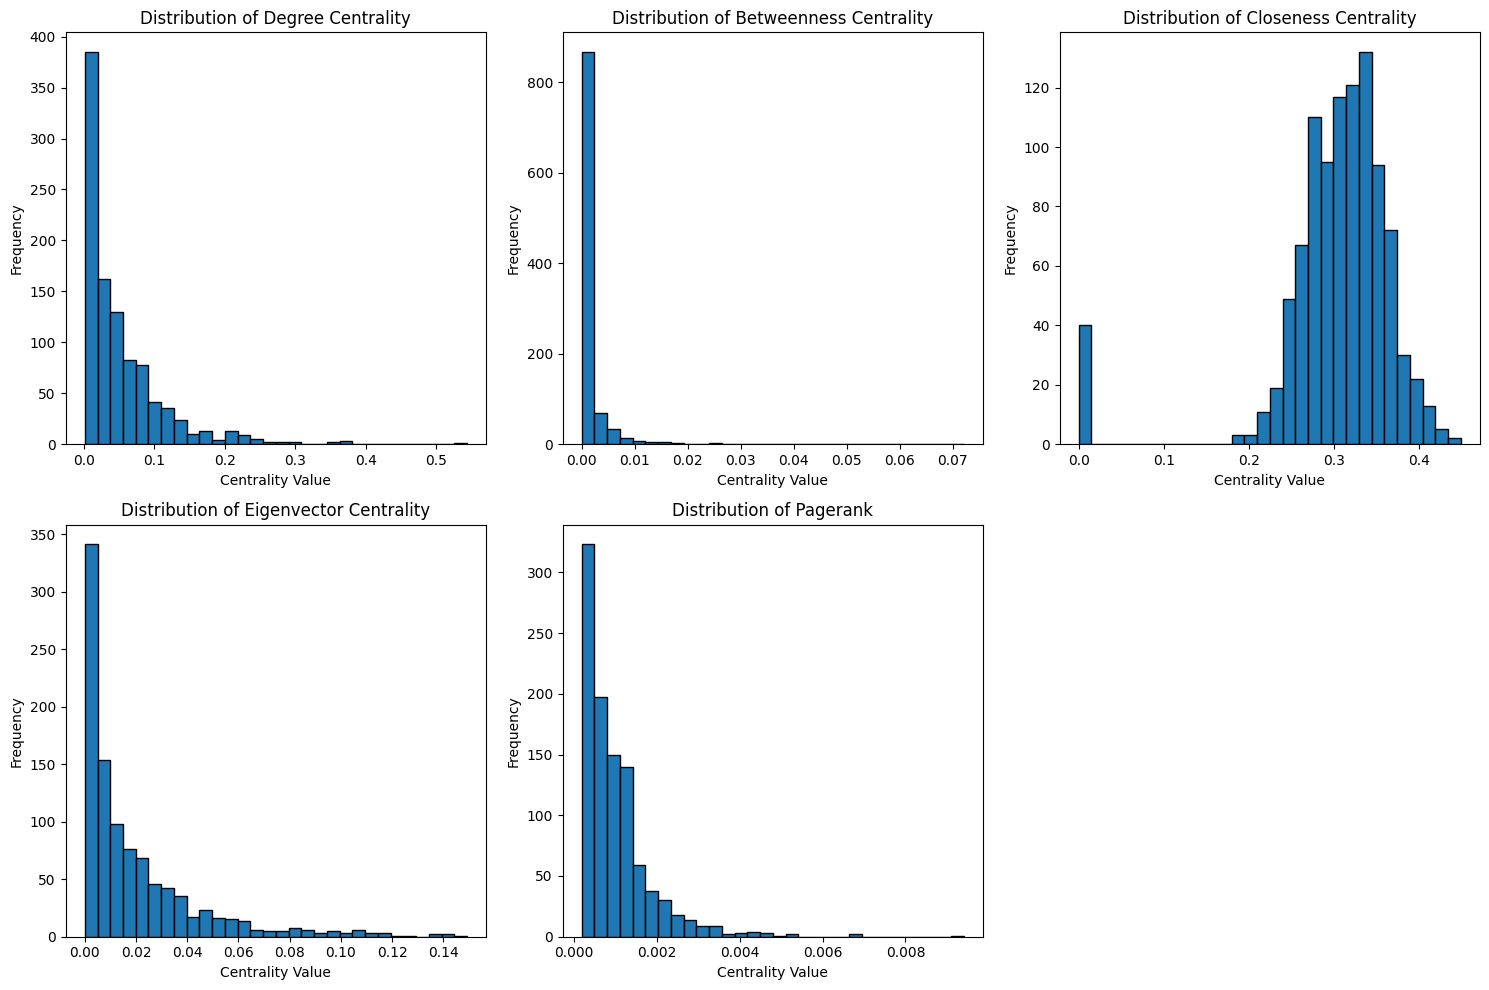

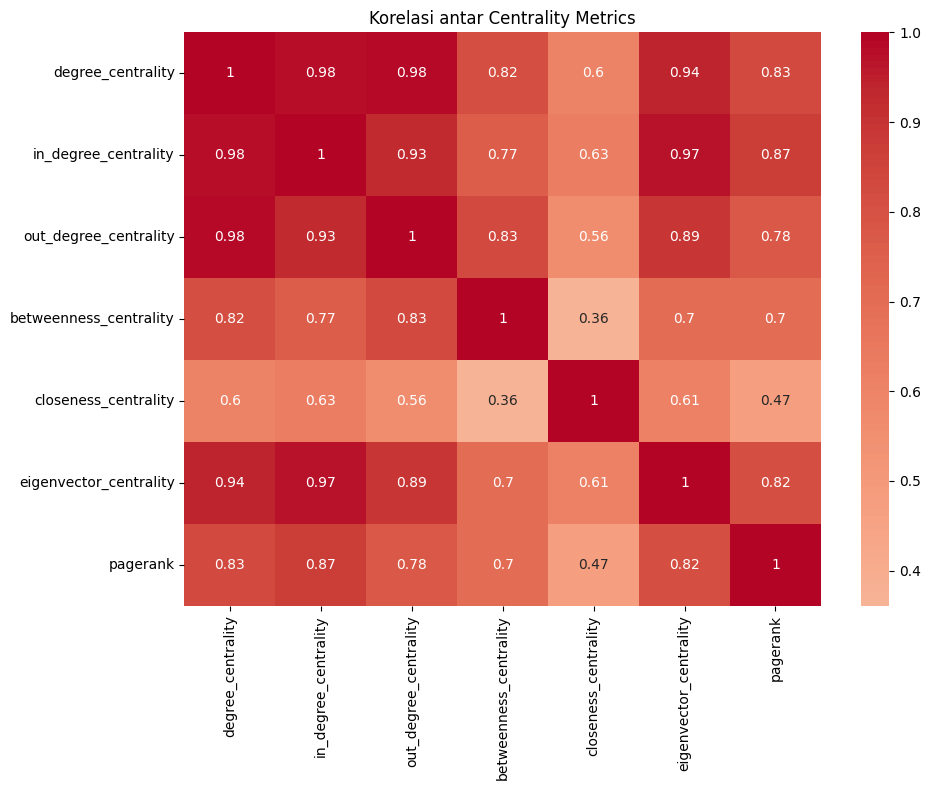


Korelasi antar Centrality Metrics:
                        degree_centrality  in_degree_centrality  \
degree_centrality                1.000000              0.977859   
in_degree_centrality             0.977859              1.000000   
out_degree_centrality            0.984453              0.925899   
betweenness_centrality           0.817429              0.765084   
closeness_centrality             0.601664              0.630339   
eigenvector_centrality           0.943567              0.967713   
pagerank                         0.833682              0.867638   

                        out_degree_centrality  betweenness_centrality  \
degree_centrality                    0.984453                0.817429   
in_degree_centrality                 0.925899                0.765084   
out_degree_centrality                1.000000                0.833465   
betweenness_centrality               0.833465                1.000000   
closeness_centrality                 0.557060                0

In [ ]:
def calculate_centrality_metrics(G):
    """
    Menghitung berbagai centrality metrics
    
    Parameters:
    G (networkx.DiGraph): Directed graph
    
    Returns:
    dict: Dictionary berisi berbagai centrality metrics
    """
    # 1. Degree Centrality
    degree_centrality = nx.degree_centrality(G)
    in_degree_centrality = nx.in_degree_centrality(G)
    out_degree_centrality = nx.out_degree_centrality(G)
    
    # 2. Betweenness Centrality
    betweenness_centrality = nx.betweenness_centrality(G)
    
    # 3. Closeness Centrality
    closeness_centrality = nx.closeness_centrality(G)
    
    # 4. Eigenvector Centrality
    eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=300)
    
    # 5. PageRank
    pagerank = nx.pagerank(G)
    
    return {
        'degree_centrality': degree_centrality,
        'in_degree_centrality': in_degree_centrality,
        'out_degree_centrality': out_degree_centrality,
        'betweenness_centrality': betweenness_centrality,
        'closeness_centrality': closeness_centrality,
        'eigenvector_centrality': eigenvector_centrality,
        'pagerank': pagerank
    }

def analyze_top_nodes(centrality_metrics, dept_dict, top_n=10):
    """
    Analisis top nodes untuk setiap centrality measure
    
    Parameters:
    centrality_metrics (dict): Dictionary berisi centrality metrics
    dept_dict (dict): Dictionary node-to-department mapping
    top_n (int): Jumlah top nodes yang ditampilkan
    
    Returns:
    DataFrame berisi top nodes untuk berbagai centrality measures
    """
    # Siapkan list untuk menyimpan top nodes
    centrality_top_nodes = {}
    
    for metric_name, centrality in centrality_metrics.items():
        # Sort nodes berdasarkan centrality value
        sorted_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:top_n]
        
        # Simpan top nodes dengan informasi tambahan
        centrality_top_nodes[metric_name] = [
            {
                'node': node, 
                'value': value, 
                'department': dept_dict.get(node, 'Unknown')
            } for node, value in sorted_nodes
        ]
    
    return centrality_top_nodes

def visualize_centrality_distribution(centrality_metrics):
    """
    Visualisasi distribusi centrality metrics
    
    Parameters:
    centrality_metrics (dict): Dictionary berisi centrality metrics
    """
    plt.figure(figsize=(15, 10))
    
    metrics_to_plot = [
        'degree_centrality', 
        'betweenness_centrality', 
        'closeness_centrality', 
        'eigenvector_centrality', 
        'pagerank'
    ]
    
    for i, metric in enumerate(metrics_to_plot, 1):
        plt.subplot(2, 3, i)
        values = list(centrality_metrics[metric].values())
        
        plt.hist(values, bins=30, edgecolor='black')
        plt.title(f'Distribution of {metric.replace("_", " ").title()}')
        plt.xlabel('Centrality Value')
        plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

def correlation_between_centrality_metrics(centrality_metrics):
    """
    Hitung korelasi antar centrality metrics
    
    Parameters:
    centrality_metrics (dict): Dictionary berisi centrality metrics
    
    Returns:
    DataFrame berisi korelasi antar metrics
    """
    # Konversi metrics ke DataFrame
    metrics_df = pd.DataFrame(centrality_metrics)
    
    # Hitung korelasi
    correlation_matrix = metrics_df.corr()
    
    # Visualisasi korelasi
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Korelasi antar Centrality Metrics')
    plt.tight_layout()
    plt.show()
    
    return correlation_matrix

# Main Execution
# Gunakan graph dari kode sebelumnya
centrality_metrics = calculate_centrality_metrics(DG)

# Analisis top nodes
top_nodes = analyze_top_nodes(centrality_metrics, dept_dict)

# Print top nodes untuk setiap metric
for metric, nodes in top_nodes.items():
    print(f"\nTop 10 Nodes - {metric.replace('_', ' ').title()}:")
    for node_info in nodes:
        print(f"Node {node_info['node']}: Value = {node_info['value']:.4f}, Department: {node_info['department']}")

# Visualisasi distribusi
visualize_centrality_distribution(centrality_metrics)

# Korelasi antar metrics
correlation_matrix = correlation_between_centrality_metrics(centrality_metrics)
print("\nKorelasi antar Centrality Metrics:")
print(correlation_matrix)

**Degree Centrality:**
- Sebagian besar node dalam jaringan memiliki koneksi langsung yang terbatas, dengan hanya beberapa node yang berfungsi sebagai "hub" penting. Ini menunjukkan struktur jaringan yang tidak merata, di mana sebagian besar node tidak memiliki banyak koneksi, sementara segelintir node menjadi titik sentral koneksi.

**Betweenness Centrality:**
- Beberapa node berperan penting sebagai penghubung strategis dalam jalur komunikasi jaringan. Node-node ini dapat dianggap sebagai "bottleneck," yang memiliki pengaruh signifikan terhadap aliran informasi antar bagian jaringan. (Mengukur seberapa sering sebuah node berada di jalur terpendek antara dua node lainnya. Node ini dianggap sebagai "penghubung" dalam jaringan.)

**Closeness Centrality:**
- Node dengan closeness tinggi cenderung terpusat, memungkinkan mereka menjangkau node lain dengan cepat. Ini menunjukkan bahwa beberapa node berperan sebagai "penyebar informasi" yang efisien, meskipun tidak semua node memiliki posisi yang menguntungkan dalam jaringan.

**Eigenvector Centrality:**
- Beberapa node tidak hanya penting secara langsung tetapi juga terhubung dengan node-node lain yang penting. Ini mengindikasikan bahwa node-node tertentu memiliki pengaruh struktural besar dalam jaringan.

**PageRank:**
- Node-node tertentu yang memiliki banyak koneksi dengan node-node penting lainnya menonjol sebagai node dengan kepentingan signifikan dalam jaringan. Hal ini relevan dalam jaringan komunikasi seperti email, di mana node dengan PageRank tinggi dapat dianggap sebagai pusat pengaruh.

**Average Degree dan Degree Distribution**

Average In-Degree: 25.4438
Average Out-Degree: 25.4438
Total Average Degree: 25.4438


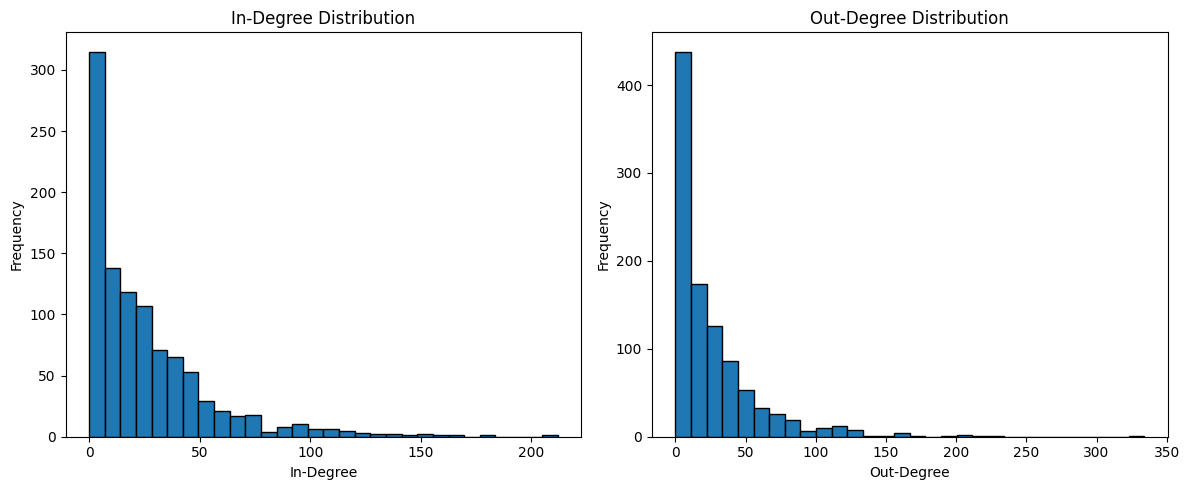

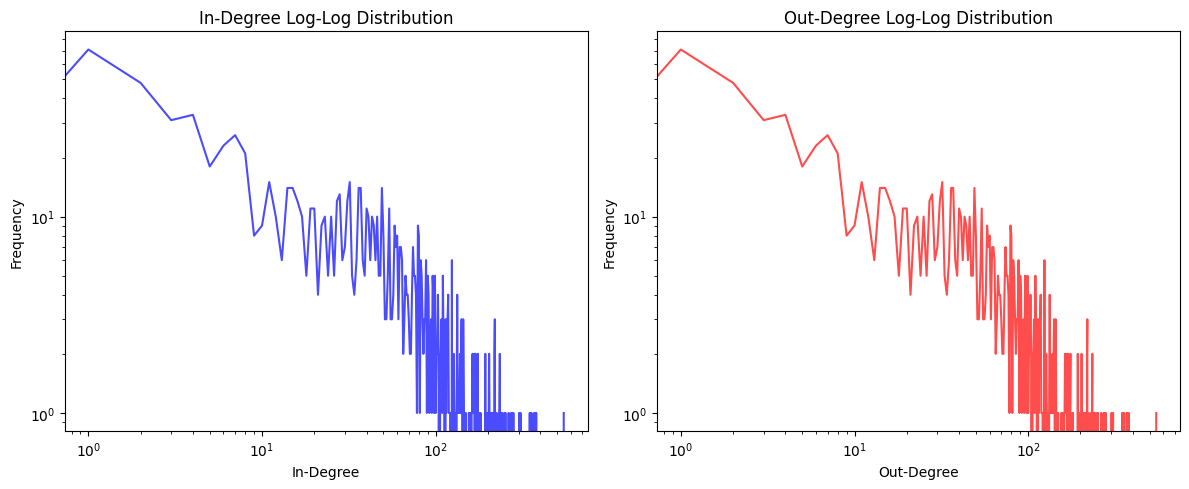


Degree Distribution Statistics:
In-Degree - Min: 0, Max: 212, Median: 18.0
Out-Degree - Min: 0, Max: 334, Median: 15.0


In [ ]:
# Calculate in-degree and out-degree
in_degrees = dict(DG.in_degree())
out_degrees = dict(DG.out_degree())

# Average Degree Calculations
avg_in_degree = np.mean(list(in_degrees.values()))
avg_out_degree = np.mean(list(out_degrees.values()))
total_avg_degree = (avg_in_degree + avg_out_degree) / 2

print(f"Average In-Degree: {avg_in_degree:.4f}")
print(f"Average Out-Degree: {avg_out_degree:.4f}")
print(f"Total Average Degree: {total_avg_degree:.4f}")

# Degree Distribution
plt.figure(figsize=(12, 5))

# In-Degree Distribution
plt.subplot(1, 2, 1)
in_degree_values = list(in_degrees.values())
plt.hist(in_degree_values, bins=30, edgecolor='black')
plt.title('In-Degree Distribution')
plt.xlabel('In-Degree')
plt.ylabel('Frequency')

# Out-Degree Distribution
plt.subplot(1, 2, 2)
out_degree_values = list(out_degrees.values())
plt.hist(out_degree_values, bins=30, edgecolor='black')
plt.title('Out-Degree Distribution')
plt.xlabel('Out-Degree')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Log-Log Plot for Degree Distribution
plt.figure(figsize=(12, 5))

# In-Degree Log-Log Plot
plt.subplot(1, 2, 1)
in_degrees_counter = nx.degree_histogram(DG.reverse())
plt.loglog(range(len(in_degrees_counter)), in_degrees_counter, 'b-', alpha=0.7)
plt.title('In-Degree Log-Log Distribution')
plt.xlabel('In-Degree')
plt.ylabel('Frequency')

# Out-Degree Log-Log Plot
plt.subplot(1, 2, 2)
out_degrees_counter = nx.degree_histogram(DG)
plt.loglog(range(len(out_degrees_counter)), out_degrees_counter, 'r-', alpha=0.7)
plt.title('Out-Degree Log-Log Distribution')
plt.xlabel('Out-Degree')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Additional Degree Statistics
print("\nDegree Distribution Statistics:")
print(f"In-Degree - Min: {min(in_degrees.values())}, Max: {max(in_degrees.values())}, Median: {np.median(list(in_degrees.values()))}")
print(f"Out-Degree - Min: {min(out_degrees.values())}, Max: {max(out_degrees.values())}, Median: {np.median(list(out_degrees.values()))}")

Dalam jaringan email, distribusi ini menunjukkan hierarki komunikasi, di mana sebagian besar researcher hanya mengirim/menerima beberapa email, sedangkan beberapa peran yang lebih aktif atau memiliki peran lebih tinggi seperti ketua departemen dsb yang memiliki volume komunikasi yang sangat tinggi juga.

**Clustering Coefficient**

Global Clustering Coefficient: 0.2201
Average Local Clustering Coefficient: 0.3657


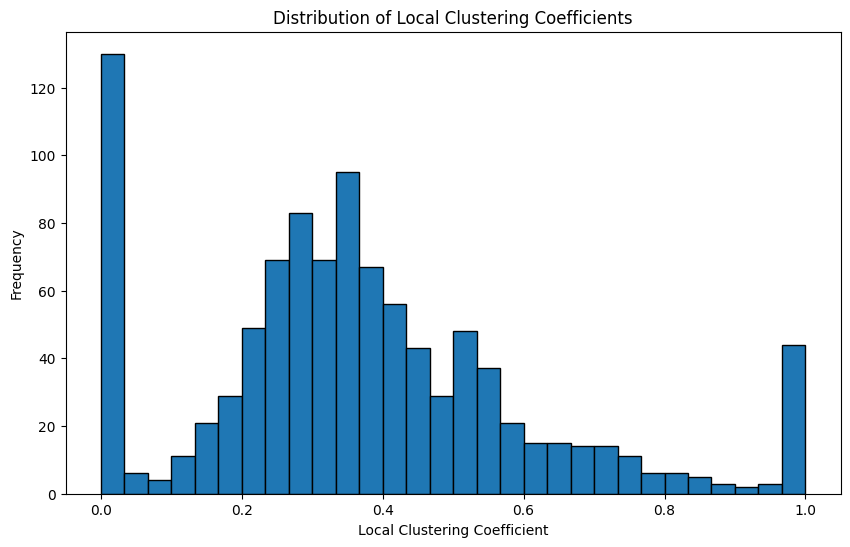


Top 5 Nodes with Highest Local Clustering Coefficients:
Node 382: Clustering Coefficient = 1.0000
Node 383: Clustering Coefficient = 1.0000
Node 398: Clustering Coefficient = 1.0000
Node 439: Clustering Coefficient = 1.0000
Node 456: Clustering Coefficient = 1.0000


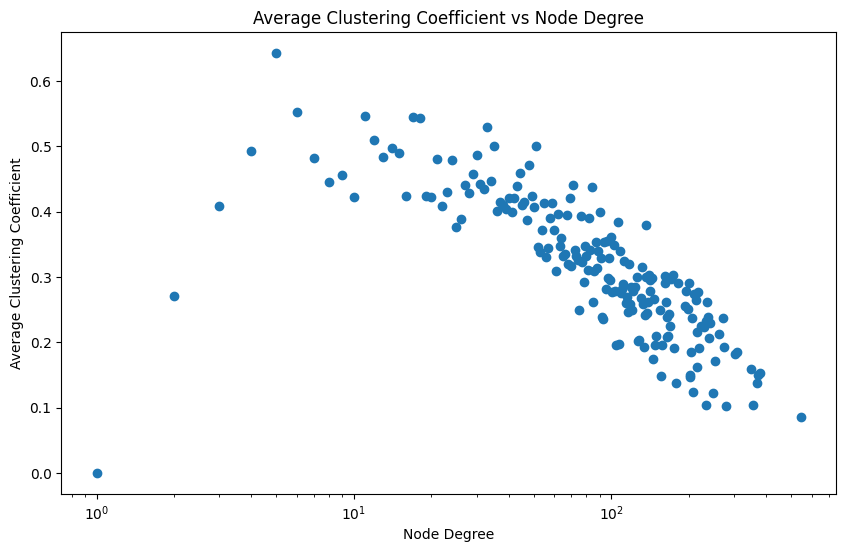


Average Clustering Coefficient by Degree Levels:
Degree 1: Average Clustering Coefficient = 0.0000
Degree 2: Average Clustering Coefficient = 0.2708
Degree 3: Average Clustering Coefficient = 0.4086
Degree 4: Average Clustering Coefficient = 0.4924
Degree 5: Average Clustering Coefficient = 0.6426
Degree 6: Average Clustering Coefficient = 0.5529
Degree 7: Average Clustering Coefficient = 0.4828
Degree 8: Average Clustering Coefficient = 0.4461
Degree 9: Average Clustering Coefficient = 0.4555
Degree 10: Average Clustering Coefficient = 0.4219


In [ ]:
# Clustering Coefficient Analysis

# 1. Global Clustering Coefficient (Transitivity)
global_clustering_coeff = nx.transitivity(DG)
print(f"Global Clustering Coefficient: {global_clustering_coeff:.4f}")

# 2. Average Local Clustering Coefficient
local_clustering_coeffs = nx.clustering(DG)
avg_local_clustering_coeff = np.mean(list(local_clustering_coeffs.values()))
print(f"Average Local Clustering Coefficient: {avg_local_clustering_coeff:.4f}")

# 3. Visualization of Local Clustering Coefficients
plt.figure(figsize=(10, 6))
plt.hist(list(local_clustering_coeffs.values()), bins=30, edgecolor='black')
plt.title('Distribution of Local Clustering Coefficients')
plt.xlabel('Local Clustering Coefficient')
plt.ylabel('Frequency')
plt.show()

# 4. Top Nodes by Local Clustering Coefficient
print("\nTop 5 Nodes with Highest Local Clustering Coefficients:")
top_clustering_nodes = sorted(local_clustering_coeffs.items(), key=lambda x: x[1], reverse=True)[:5]
for node, coeff in top_clustering_nodes:
    print(f"Node {node}: Clustering Coefficient = {coeff:.4f}")

# 5. Clustering Coefficient by Degree
def analyze_clustering_by_degree(G, clustering_coeffs):
    degrees = dict(G.degree())
    degree_clusters = {}
    
    for node, cluster_coeff in clustering_coeffs.items():
        degree = degrees[node]
        if degree not in degree_clusters:
            degree_clusters[degree] = []
        degree_clusters[degree].append(cluster_coeff)
    
    avg_clusters_by_degree = {d: np.mean(coeffs) for d, coeffs in degree_clusters.items()}
    
    plt.figure(figsize=(10, 6))
    plt.scatter(list(avg_clusters_by_degree.keys()), list(avg_clusters_by_degree.values()))
    plt.title('Average Clustering Coefficient vs Node Degree')
    plt.xlabel('Node Degree')
    plt.ylabel('Average Clustering Coefficient')
    plt.xscale('log')
    plt.show()
    
    return avg_clusters_by_degree

clustering_by_degree = analyze_clustering_by_degree(DG, local_clustering_coeffs)
print("\nAverage Clustering Coefficient by Degree Levels:")
for degree, avg_cluster in sorted(clustering_by_degree.items())[:10]:
    print(f"Degree {degree}: Average Clustering Coefficient = {avg_cluster:.4f}")

**Clustering Coefficient:**

- Global Clustering Coefficient (22.01%): Clustering coefficient mengukur kemungkinan dua simpul yang terhubung ke simpul yang sama juga saling terhubung. Jaringan ini memiliki struktur yang cukup tersebar, dengan hanya sebagian kecil dari koneksi membentuk kluster lokal. Jaringan ini memiliki struktur yang lebih "sparse" atau tersebar, bukan jaringan yang sangat klustered.
- Average Local Clustering Coefficient (36.57%): Mengukur seberapa banyak tetangga dari sebuah node saling terhubung. Terdapat klustering lokal yang moderat, di mana sebagian tetangga dari setiap node saling terhubung. Node dengan koneksi lebih sedikit lebih cenderung membentuk segitiga.
- Node dengan Clustering Coefficient Maksimal (1.0000): Beberapa node memiliki hubungan sempurna antara tetangganya, membentuk komunitas lokal penuh (clique).

**Diameter & Average Path Length**

Network Diameter (Weak Connected Component): 7
Average Path Length (Weak Connected Component): 2.5869


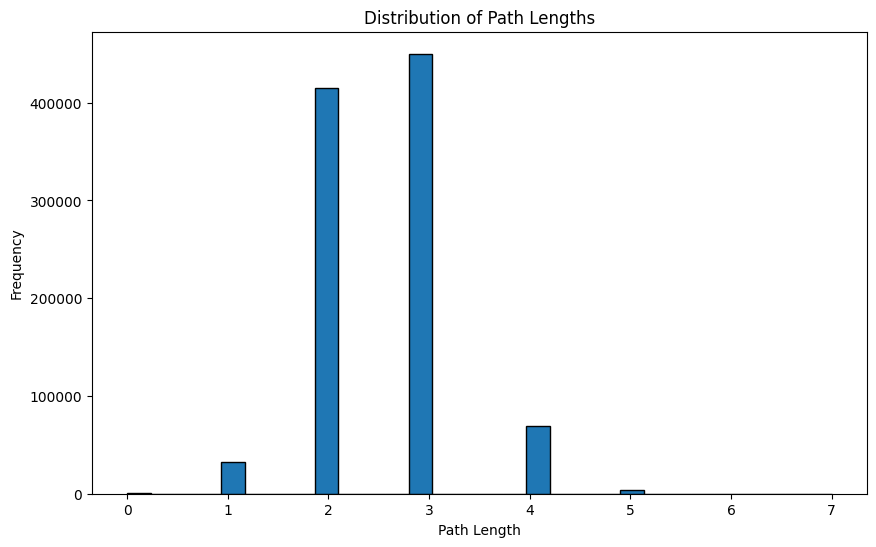


Number of Weakly Connected Components: 20
Size of Largest Weakly Connected Component: 986 nodes


In [ ]:
# Diameter & Average Path Length Analysis

# 1. Find the largest weakly connected component
largest_wcc = max(nx.weakly_connected_components(DG), key=len)
wcc_subgraph = DG.subgraph(largest_wcc)

# 2. Convert to undirected graph for path length calculations
UG = wcc_subgraph.to_undirected()

# 3. Diameter of the Weak Connected Component
wcc_diameter = nx.diameter(UG)
print(f"Network Diameter (Weak Connected Component): {wcc_diameter}")

# 4. Average Path Length of the Weak Connected Component
avg_path_length = nx.average_shortest_path_length(UG)
print(f"Average Path Length (Weak Connected Component): {avg_path_length:.4f}")

# 5. Visualization of Path Length Distribution
path_lengths = dict(nx.all_pairs_shortest_path_length(UG))

# Flatten path lengths
all_path_lengths = []
for node_paths in path_lengths.values():
    all_path_lengths.extend(list(node_paths.values()))

plt.figure(figsize=(10, 6))
plt.hist(all_path_lengths, bins=30, edgecolor='black')
plt.title('Distribution of Path Lengths')
plt.xlabel('Path Length')
plt.ylabel('Frequency')
plt.show()

# Additional network connectivity information
print(f"\nNumber of Weakly Connected Components: {nx.number_weakly_connected_components(DG)}")
print(f"Size of Largest Weakly Connected Component: {len(largest_wcc)} nodes")

- Setiap WCC merupakan kelompok node yang terisolasi secara topologi, graf tersebut dapat dipisah menjadi 20 subgraf yang tidak saling terhubung satu sama lain
-  Komponen terhubung lemah terbesar (WCC terbesar) mencakup 986 node

Strongly Connected Component Analysis:
Number of Strongly Connected Components: 203
Size of Largest Strongly Connected Component: 803 nodes
Directed Diameter (Largest Strongly Connected Component): 6
Average Directed Path Length: 2.5475


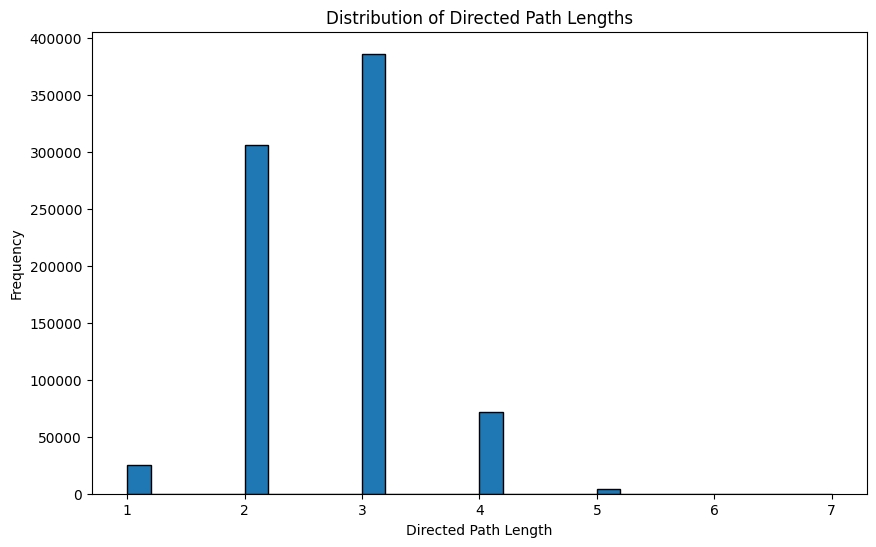


Directed Path Length Statistics:


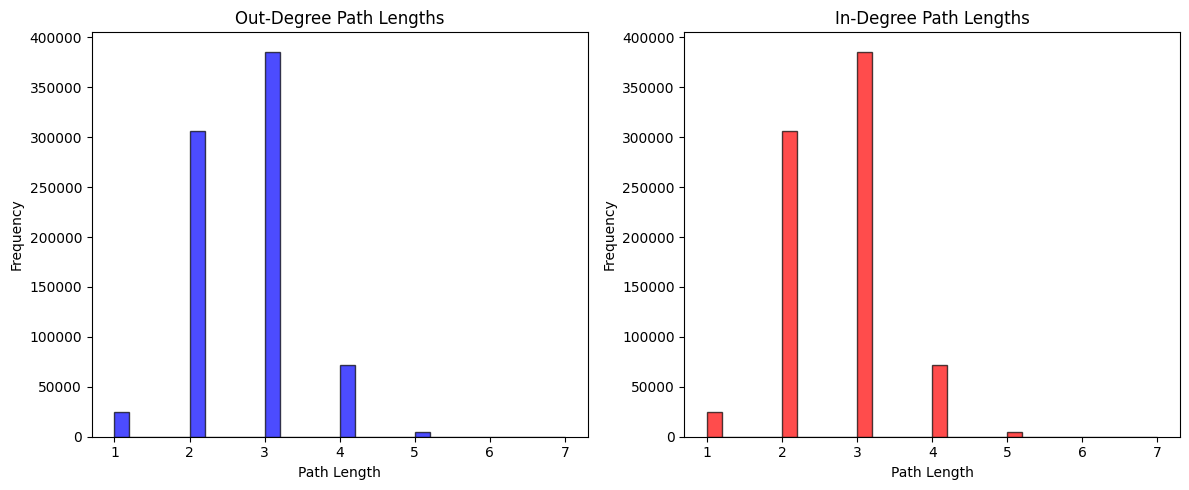

In [ ]:
# Detailed Directed Network Analysis
def analyze_directed_network_paths(DG):
    # 1. Strongly Connected Components
    strongly_connected_comps = list(nx.strongly_connected_components(DG))
    largest_scc = max(strongly_connected_comps, key=len)
    scc_subgraph = DG.subgraph(largest_scc)
    
    print("Strongly Connected Component Analysis:")
    print(f"Number of Strongly Connected Components: {len(strongly_connected_comps)}")
    print(f"Size of Largest Strongly Connected Component: {len(largest_scc)} nodes")
    
    # 2. Directed Path Calculations
    # Compute directed path lengths for the largest strongly connected component
    try:
        # Diameter (longest shortest path)
        scc_diameter = nx.diameter(scc_subgraph)
        print(f"Directed Diameter (Largest Strongly Connected Component): {scc_diameter}")
    except nx.NetworkXError:
        print("Cannot compute diameter for strongly connected component")
    
    # 3. Average Directed Path Length
    try:
        avg_directed_path_length = nx.average_shortest_path_length(scc_subgraph)
        print(f"Average Directed Path Length: {avg_directed_path_length:.4f}")
    except nx.NetworkXError:
        print("Cannot compute average path length for strongly connected component")
    
    # 4. Generalized Path Length Analysis
    def compute_directed_path_lengths(G):
        path_lengths = []
        for source in G.nodes():
            for target in G.nodes():
                if source != target:
                    try:
                        path_length = nx.shortest_path_length(G, source, target)
                        path_lengths.append(path_length)
                    except nx.NetworkXNoPath:
                        # If no path exists, we skip
                        continue
        return path_lengths
    
    # Compute path lengths for the entire graph
    all_path_lengths = compute_directed_path_lengths(DG)
    
    # 5. Visualization of Directed Path Lengths
    plt.figure(figsize=(10, 6))
    plt.hist(all_path_lengths, bins=30, edgecolor='black')
    plt.title('Distribution of Directed Path Lengths')
    plt.xlabel('Directed Path Length')
    plt.ylabel('Frequency')
    plt.show()
    
    # 6. Additional Path-related Metrics
    print("\nDirected Path Length Statistics:")
    
    # 7. In-Degree and Out-Degree Path Analysis
    in_degree_paths = []
    out_degree_paths = []
    
    for node in DG.nodes():
        # Paths from this node to others (out-degree paths)
        out_paths = [len(nx.shortest_path(DG, node, target)) - 1 
                     for target in DG.nodes() 
                     if node != target and nx.has_path(DG, node, target)]
        
        # Paths to this node from others (in-degree paths)
        in_paths = [len(nx.shortest_path(DG, source, node)) - 1 
                    for source in DG.nodes() 
                    if node != source and nx.has_path(DG, source, node)]
        
        out_degree_paths.extend(out_paths)
        in_degree_paths.extend(in_paths)
    
    # Visualize In-Degree and Out-Degree Path Distributions
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(out_degree_paths, bins=30, edgecolor='black', color='blue', alpha=0.7)
    plt.title('Out-Degree Path Lengths')
    plt.xlabel('Path Length')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    plt.hist(in_degree_paths, bins=30, edgecolor='black', color='red', alpha=0.7)
    plt.title('In-Degree Path Lengths')
    plt.xlabel('Path Length')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'strongly_connected_components': len(strongly_connected_comps),
        'largest_scc_size': len(largest_scc),
        'path_lengths': all_path_lengths
    }

# Run the analysis
network_metrics = analyze_directed_network_paths(DG)

**Scaling Exponent**

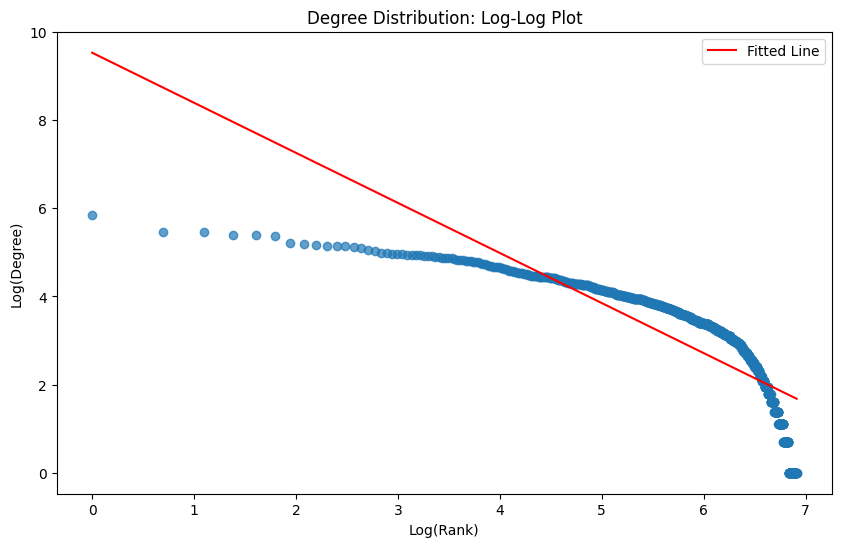


1. Scaling Exponent (Power Law Analysis):
Scaling Exponent: 1.1358
R-squared: 0.6754

2. Assortativity Metrics:
Degree Assortativity: -0.0110
Department Assortativity: 0.3162


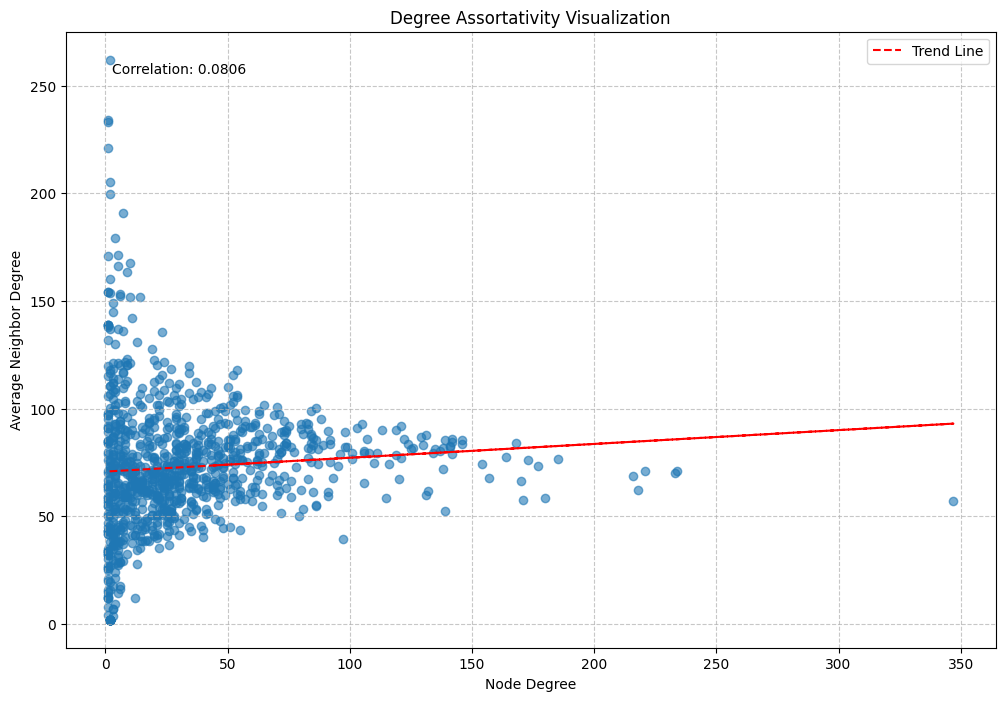


Assortativity Correlation: 0.0806

3. Modularity Analysis:


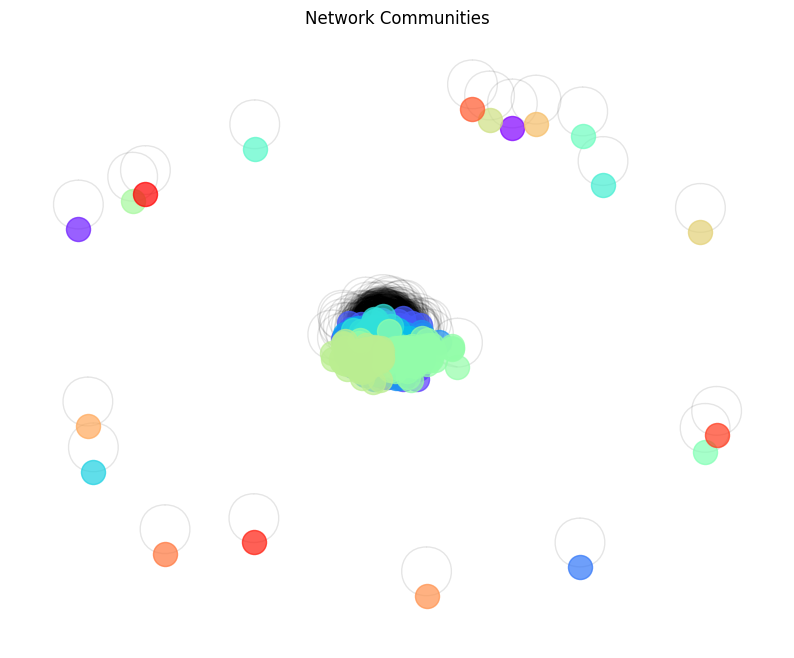

Modularity: 0.4328

Community Size Distribution:
Community 3: 262 nodes
Community 16: 144 nodes
Community 5: 130 nodes
Community 14: 125 nodes
Community 9: 112 nodes
Community 2: 93 nodes
Community 7: 64 nodes
Community 6: 56 nodes
Community 0: 1 nodes
Community 1: 1 nodes


In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import community as community_louvain
import gzip

# Reuse the edge reading function
def read_edges(filename):
    edges = []
    with gzip.open(filename, 'rt') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 2:
                source = int(parts[0])
                target = int(parts[1])
                edges.append((source, target))
    return edges

# Create the directed graph
edges = read_edges("email-Eu-core.txt.gz")
DG = nx.DiGraph(edges)

# Convert to undirected for some analyses
UG = DG.to_undirected()

def analyze_network_metrics(G):
    # 1. Scaling Exponent (Power Law Exponent)
    def calculate_scaling_exponent(degrees):
        # Fit power law distribution
        degrees = sorted(degrees, reverse=True)
        log_degrees = np.log(degrees)
        log_ranks = np.log(range(1, len(degrees) + 1))
        
        # Linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(log_ranks, log_degrees)
        
        plt.figure(figsize=(10, 6))
        plt.scatter(log_ranks, log_degrees, alpha=0.7)
        plt.plot(log_ranks, intercept + slope * log_ranks, 'r', label='Fitted Line')
        plt.title('Degree Distribution: Log-Log Plot')
        plt.xlabel('Log(Rank)')
        plt.ylabel('Log(Degree)')
        plt.legend()
        plt.show()
        
        return -slope, r_value**2

    # Degree distribution
    degrees = [d for n, d in G.degree()]
    scaling_exponent, r_squared = calculate_scaling_exponent(degrees)
    print("\n1. Scaling Exponent (Power Law Analysis):")
    print(f"Scaling Exponent: {scaling_exponent:.4f}")
    print(f"R-squared: {r_squared:.4f}")

    # 2. Assortativity
    # Degree Assortativity
    degree_assortativity = nx.degree_assortativity_coefficient(G)
    print("\n2. Assortativity Metrics:")
    print(f"Degree Assortativity: {degree_assortativity:.4f}")

    # Attribute Assortativity (using departments if available)
    try:
        # Read departments
        departments = pd.read_csv("email-Eu-core-department-labels.txt.gz", sep=" ", header=None, names=["node", "department"])
        dept_dict = dict(zip(departments['node'], departments['department']))
        
        # Map departments to graph nodes
        nx.set_node_attributes(G, dept_dict, 'department')
        
        # Compute attribute assortativity
        attribute_assortativity = nx.attribute_assortativity_coefficient(G, 'department')
        print(f"Department Assortativity: {attribute_assortativity:.4f}")
    except Exception as e:
        print(f"Could not compute attribute assortativity: {e}")

    def visualize_assortativity(G):
        """
        Visualize degree assortativity by plotting node degrees
        and their connections to high/low degree neighbors.
        """
        # Get node degrees
        degrees = dict(G.degree())
        
        # Create a scatter plot of node degrees
        plt.figure(figsize=(12, 8))
        
        # Compute median degree to split nodes
        median_degree = np.median(list(degrees.values()))
        
        # Scatter plot of node degrees and their neighbor degrees
        x_degrees = []  # Node's degree
        y_neighbor_degrees = []  # Average neighbor degree
        
        for node in G.nodes():
            # Calculate average degree of neighbors
            neighbor_degrees = [degrees[neighbor] for neighbor in G.neighbors(node)]
            avg_neighbor_degree = np.mean(neighbor_degrees) if neighbor_degrees else 0
            
            x_degrees.append(degrees[node])
            y_neighbor_degrees.append(avg_neighbor_degree)
        
        # Scatter plot
        plt.scatter(x_degrees, y_neighbor_degrees, alpha=0.6)
        plt.title('Degree Assortativity Visualization')
        plt.xlabel('Node Degree')
        plt.ylabel('Average Neighbor Degree')
        
        # Add best fit line
        z = np.polyfit(x_degrees, y_neighbor_degrees, 1)
        p = np.poly1d(z)
        plt.plot(x_degrees, p(x_degrees), "r--", label='Trend Line')
        
        # Calculate and display correlation
        correlation = np.corrcoef(x_degrees, y_neighbor_degrees)[0, 1]
        plt.text(0.05, 0.95, f'Correlation: {correlation:.4f}', 
                 transform=plt.gca().transAxes, 
                 verticalalignment='top')
        
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()
        
        return correlation

    # Call the visualization function after assortativity calculation
    try:
        assortativity_correlation = visualize_assortativity(G)
        print(f"\nAssortativity Correlation: {assortativity_correlation:.4f}")
    except Exception as e:
        print(f"Could not visualize assortativity: {e}")
        assortativity_correlation = None
        
    # 3. Modularity
    def compute_modularity(G):
        # Use Louvain method for community detection
        partition = community_louvain.best_partition(G.to_undirected())
        
        # Compute modularity
        modularity = community_louvain.modularity(partition, G.to_undirected())
        
        # Visualize communities
        plt.figure(figsize=(10, 8))
        pos = nx.spring_layout(G)
        
        # Color nodes by community
        communities = set(partition.values())
        colors = plt.cm.rainbow(np.linspace(0, 1, len(communities)))
        
        for i, comm_color in zip(communities, colors):
            nx.draw_networkx_nodes(G, pos, 
                                   nodelist=[n for n in G.nodes() if partition[n] == i],
                                   node_color=[comm_color], 
                                   alpha=0.7)
        
        nx.draw_networkx_edges(G, pos, alpha=0.1)
        plt.title('Network Communities')
        plt.axis('off')
        plt.show()
        
        return modularity, partition

    # Compute Modularity
    print("\n3. Modularity Analysis:")
    modularity, partition = compute_modularity(G)
    print(f"Modularity: {modularity:.4f}")
    
    # Community size distribution
    community_sizes = {}
    for community in set(partition.values()):
        community_sizes[community] = sum(1 for p in partition.values() if p == community)
    
    print("\nCommunity Size Distribution:")
    for comm, size in sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"Community {comm}: {size} nodes")

    # Update the return dictionary
    return {
        'scaling_exponent': scaling_exponent,
        'degree_assortativity': degree_assortativity,
        'modularity': modularity,
        'assortativity_correlation': assortativity_correlation
    }

# Run the analysis
network_metrics = analyze_network_metrics(UG)

**Scaling Exponent:**
- Jaringan menunjukkan karakteristik power-law dengan scaling exponent sebesar 1,1358. Ini menunjukkan banyaknya node dengan koneksi kecil dan hanya beberapa node dengan koneksi tinggi (hubs), meskipun distribusinya tidak sepenuhnya konsisten dengan model power-law (R-squared 0,6754).

**Degree Assortativity (-0.0110):** 
- Hampir tidak ada korelasi antara derajat node yang terhubung. Ini menunjukkan hubungan acak, yang khas dalam jaringan komunikasi. (Neutral Network)
**Department Assortativity (0.3162):** 
- Node cenderung lebih sering terhubung dengan node lain dari departemen yang sama, yang masuk akal dalam konteks jaringan komunikasi seperti email.
(each node links only to node with the same degree) (mendekati Assortative)

**Modularity dan Komunitas:**
- Modularity (0.4328) menunjukkan adanya struktur komunitas yang signifikan. Node lebih sering terhubung di dalam komunitas masing-masing dibandingkan antar komunitas.
- Terdapat komunitas besar dan kecil, dengan komunitas terbesar mencakup 262 node. Hal ini mencerminkan pola interaksi yang terpusat dalam kelompok tertentu, kemungkinan besar sesuai dengan struktur organisasi.

**Kesimpulan**

Jaringan ini memiliki sifat khas jaringan komunikasi: efisien dalam konektivitas global (panjang jalur pendek), terorganisir dalam komunitas (modularity signifikan), tetapi tetap cukup acak dalam pola koneksi antar node (degree assortativity rendah). Jaringan ini menunjukkan pola interaksi lokal yang kuat di dalam kelompok tertentu (misalnya, departemen), sementara beberapa node memainkan peran penting sebagai hub atau penghubung antar komunitas. Analisis ini dapat membantu memahami dinamika komunikasi dan struktur organisasi jaringan.